# Predicting lung cancer survival time

In [132]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from joblib import load
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sksurv.linear_model import CoxnetSurvivalAnalysis
from scipy.integrate import trapz
import shap
import xgboost

sns.set_style("ticks")

project_path = Path("../../")
model_path = project_path / "model"
src_path = project_path / "python" / "src"
data_path = project_path / "data"
train_dir, test_dir = data_path / "x_train", data_path / "x_test"

sys.path.append(str(src_path))

from preprocessing import load_data, age_fillna, hist_fillna
from visualization import plot_diag_matrix_corr
from selection.features import ReduceVIF, forward_selection
from selection.models import train_model_gridsearch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Challenge description


### Goal



The challenge proposed by Owkin is a supervised survival prediction problem: predict the survival time of a patient (remaining days to live) from one three-dimensional CT scan (grayscale image) and a set of pre-extracted quantitative imaging features, as well as clinical data. To each patient corresponds one CT scan, and one binary segmentation mask. The segmentation mask is a binary volume of the same size as the CT scan, except that it is composed of zeroes everywhere there is no tumour, and 1 otherwise. This segmentation mask was built based on annotations from radiologists, who delineated by hand the tumor(s).


### Data



__Inputs__

For each patient, there is four inputs:

  1. Images (one scan and one mask per patient): Crops of both the scan and the mask, centered around the tumor region. Those crops are of fixed 92^3 mm^3 size.
  2. Radiomics features (an ensemble of 53 quantitative features per patient, extracted from the scan).
  3. Clinical data

__Outputs__

Outputs must be positive floats which represent the predicted survival time in days. The file `train/output.csv` simply contains two columns, indexed by patient id: one column represents the observed time to event, while the other represents the censorship (1=event observed is death, 0=event observed is the last time patient was seen alive, the patient then escaped the study).

## Dive into the challenge



### Exploration, visualisation and features engineering

In [5]:
radiomics, clinical, target = load_data(train_dir, target=True)

#### radiomics features

In [6]:
print('n = {}\n'
      'd = {}'.format(*radiomics.shape))
radiomics.head()

n = 300
d = 53


,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


In [11]:
radiomics[radiomics.isna().any(axis=1)]

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,


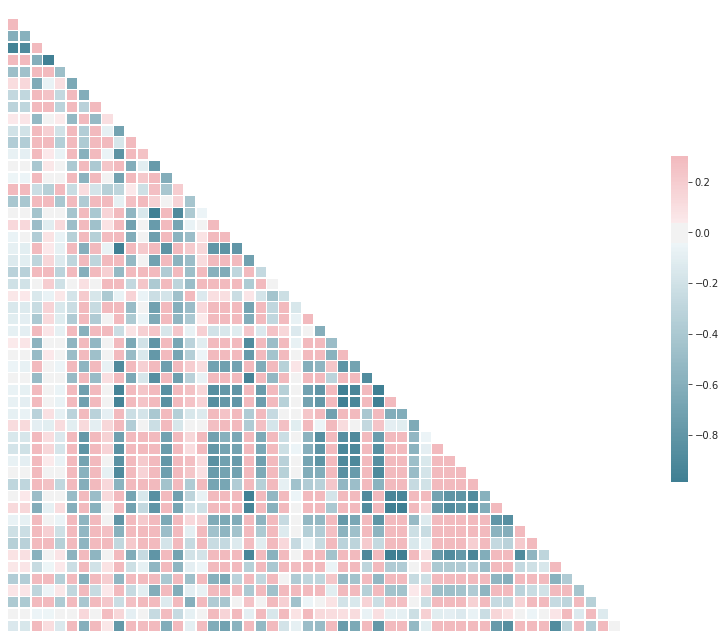

In [12]:
plot_diag_matrix_corr(radiomics, show_labels=False)

By looking at the matrix correlation, we see that many features are higly correlated beetwen each over. This colinearity may entails conditionnement problems for our matrix $X^{\top}X$ when apply regression models.

##### Compute VIF

We going to use the variance inflation factor (VIF) to diagnostic the multicollinearity in this dataset, which is computed for each explanatory variable.

If we consider the following linear model :

$$Y = \beta_0 + \beta_1 X_1 + ... + \beta_d X_d + \varepsilon$$

We know that the standard error of the estimate of $\beta_j$ is the square root of the $j+1$ diagonal element of $s^2(X^\top X)^{-1}$, where $s$ is the root mean squared error (RMSE). The square of this standard error, 
the estimated variance of the estimate of $\beta_j$, can be expressed as:

$$\hat{\text{var}}(\hat{\beta}_j) = \frac{s^2}{(n-1)\hat{\text{var}}(X_j)}\cdot \frac{1}{1-R^2_j}$$.

Where $R^2_j$ is the multiple $R^2$ for the regression of $X_j$ on the other covariates (a regression that does not involve the response variable $Y$). The terme $\frac{1}{1-R^2_j}$ is the VIF. It reflects all other factors that influence the uncertainty in the coefficient estimates. The VIF equals 1 when the vector $X_j$ is orthogonal to each column of the design matrix for the regression of $X_j$ on the other covariates. By contrast, the VIF is greater than 1 when the vector $X_j$ is not orthogonal to all columns of the design matrix for the regression of $X_j$ on the other covariates.

So we put the VIF threshold at the level of 10.0, which is a commonly used value, meaning if the VIF is above 10.0 we should consider there is effect of multicollinearity on your fitted model.

In [7]:
transformer = ReduceVIF(thresh=10.0, index='PatientID')
radiomics_reduced = transformer.fit_transform(radiomics.reset_index())
radiomics_reduced.head()

ReduceVIF fit
ReduceVIF transform


/home/axel/miniconda3/envs/owkin-test/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping original_firstorder_Maximum with vif=inf
Dropping original_shape_Sphericity with vif=10307614.543674767
Dropping original_glcm_Id with vif=1956911.7396282535
Dropping original_glcm_Idmn with vif=763290.5029901204
Dropping original_glcm_SumEntropy with vif=68539.1043696255
Dropping original_glcm_Idn with vif=54964.816291674935
Dropping original_firstorder_Entropy with vif=44577.95098043065
Dropping original_glrlm_RunPercentage with vif=37858.15913186682
Dropping original_glcm_SumAverage with vif=26673.790340800486
Dropping original_glrlm_HighGrayLevelRunEmphasis with vif=20326.66735018643
Dropping original_glrlm_ShortRunEmphasis with vif=13194.373512610042
Dropping original_shape_Compactness1 with vif=10170.658839503289
Dropping original_firstorder_Minimum with vif=8327.323793096739
Dropping original_glcm_DifferenceEntropy with vif=5375.936256022291
Dropping original_glcm_Imc2 with vif=3903.695672487128
Dropping original_firstorder_MeanAbsoluteDeviation with vif=3829.7343587550

,original_shape_Compactness2,original_shape_SurfaceVolumeRatio,original_firstorder_Energy,original_firstorder_Kurtosis,original_firstorder_Median,original_firstorder_Skewness,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_Contrast,original_glcm_JointEnergy,original_glrlm_GrayLevelNonUniformity,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis
PatientID,,,,,,,,,,,,,
202.0,0.274892,0.275228,3.942944e+09,1.592466,-266.0,-0.281714,546253.499762,-5334.563631,54.336816,0.005920,555.378594,0.003384,0.004444
371.0,0.188210,0.240727,3.122890e+09,3.371013,-15.0,-1.216062,331155.230396,-6857.579704,16.868781,0.025532,1766.619373,0.002069,0.003633
246.0,0.265740,0.200766,1.059535e+09,7.585494,2.0,-2.153344,54523.086867,-1618.363118,7.040623,0.066569,3462.816344,0.001635,0.004869
240.0,0.255406,0.323878,6.583324e+08,4.281865,-37.0,-1.437836,166735.779994,-3968.921514,13.656782,0.015048,683.869792,0.002680,0.003901
284.0,0.199424,0.327241,8.072532e+08,8.999616,14.0,-2.438490,658805.553990,-10509.915485,20.121147,0.029317,962.094760,0.004704,0.023273


In [9]:
print(f'We keep {radiomics_reduced.shape[1]} features from our {radiomics.shape[1]} because of too strong multicollinearity.')

We keep 13 features from our 53 because of too strong multicollinearity.


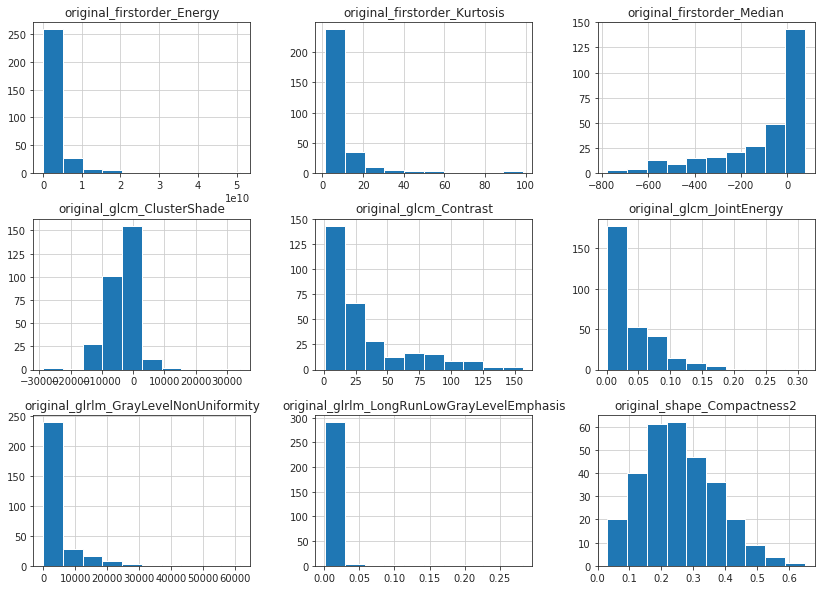

In [107]:
_ = radiomics_reduced.hist(figsize=(14, 10))

#### Clinical data

In [ ]:
print('n = {}\n'
      'd = {}'.format(*clinical.shape))
clinical.head()

n = 300
d = 6


,Histology,Mstage,Nstage,SourceDataset,Tstage,age
PatientID,,,,,,
202,adenocarcinoma,0,0,l2,2,66.0000
371,large cell,0,2,l1,4,64.5722
246,squamous cell carcinoma,0,3,l1,2,66.0452
240,nos,0,2,l1,3,59.3566
284,squamous cell carcinoma,0,3,l1,4,71.0554


In [8]:
nb_rows_with_nan = clinical[clinical.isna().any(axis=1)].shape[0]
print(f'Number of rows containing nan values: {nb_rows_with_nan}')

Number of rows containing nan values: 30


In [9]:
for column in clinical.columns:
    print(f'{column} missing values: {clinical[column][clinical[column].isna()].shape[0]}')

Histology missing values: 20
Mstage missing values: 0
Nstage missing values: 0
SourceDataset missing values: 0
Tstage missing values: 0
age missing values: 16


There is a significant amoung of missing values in the clinical dataset. One way, not the better one, is to drop all of the rows that contains a missing values. By doing that, we will loose a lot of potential information in our data.

An another method is to try to fill the missing values by some logical information : 
- Fill with statistics based on the distribution of each feature:
  - continuous features : fill missing value with mean of observations with same information
  - categorical features : Apply majority vote on observations with same informations
- We can train a model to predict  each feature of the dataset and fill the missing value by adding prediction of those regression models

##### Fill age column

We are going to train a non linear model SVR model to predict all missing values in the age column.

In [14]:
# data
cat_cols = list(clinical.columns[:-1])
age_col = [clinical.columns[-1]]
data = clinical.dropna()

features_processing_reg_age = ColumnTransformer([
 ("encode_categorical_columns", OneHotEncoder(sparse=False), cat_cols),
 ("rescale_age_column", StandardScaler(), age_col),
 ])

data_processed = features_processing_reg_age.fit_transform(data)
X, y = data_processed[:, :-1], data_processed[:, -1]

print(f'Train: {X.shape}\n'
      f'Test: {X.shape}')

Train: (270, 17)
Test: (270, 17)


In [ ]:
# Set train variable to True if you want to train a new SVR
train = False

date = str(datetime.now()).replace(' ', '_')
Cs = list(np.logspace(-3, 3, 5))
gammas = 10. ** np.arange(1, 2)
degrees = np.r_[2, 3]
parameters = {'kernel': ['poly'], 'C': Cs,
              'gamma': gammas, 'degree': degrees}

if train:
    date = str(datetime.now()).replace(' ', '_')
    svr_age = train_model_gridsearch(model=SVR(), X=X, y=y,
                                      parameters=parameters, cv=3,
                                      output_path=model_path / f'svr_age_{date}.joblib')

Generalization score for polynomial kernel: train:0.22463977357569642, test: 0.23826071373763535
Best params:  {'C': 0.001, 'degree': 2, 'gamma': 10.0, 'kernel': 'poly'}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


As expected, performance are not great but it will be suffisant to handle missing values.

In [19]:
svr_age = load(model_path / 'svr_age_2020-02-11_19_31_37.568277.joblib')
clinical = clinical.apply(lambda row: age_fillna(row, svr_age, features_processing_reg_age), axis=1)

##### Fill Histology column

In [20]:
# data
cat_cols = list(clinical.columns[1:-1])
age_col = [clinical.columns[-1]]
hist_col = [clinical.columns[0]]
data = clinical.dropna()

features_processing_reg_hist = ColumnTransformer([
 ("encode_histology_column", OrdinalEncoder(), hist_col),                                                 
 ("encode_categorical_columns", OneHotEncoder(sparse=False), cat_cols),
 ("rescale_age_column", StandardScaler(), age_col)
 ])

data_processed = features_processing_reg_hist.fit_transform(data)
X, y = data_processed[:, 1:], data_processed[:, 0]

print(f'Train: {X.shape}\n'
      f'Test: {X.shape}')

Train: (280, 14)
Test: (280, 14)


In [ ]:
# Set train variable to True if you want to train a new SVC
train = False

# We take the same parameters as the precedent training
parameters = {'kernel': ['poly', 'rbf', 'linear'], 'C': Cs,
              'gamma': gammas, 'degree': degrees}
date = str(datetime.now()).replace(' ', '_')

if train:
    svc_hist = train_model_gridsearch(model=SVC(decision_function_shape='ovo'),
                                      X=X, y=y, parameters=parameters, cv=3,
                                      output_path=model_path / f'svc_hist_{date}.joblib')

Generalization score for polynomial kernel: train:0.6008403361344538, test: 0.4523809523809524
Best params:  {'C': 1.0, 'degree': 2, 'gamma': 10.0, 'kernel': 'linear'}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
svc_hist = load(model_path / 'svc_hist_2020-02-11_19_52_36.445055.joblib')

In [25]:
clinical = clinical.apply(lambda row: hist_fillna(row, svc_hist,
                                                  features_processing_reg_hist), axis=1)

In [26]:
for column in clinical.columns:
    print(f'{column} missing values: {clinical[column][clinical[column].isna()].shape[0]}')

Histology missing values: 6
Mstage missing values: 0
Nstage missing values: 0
SourceDataset missing values: 0
Tstage missing values: 0
age missing values: 6


In [27]:
print(f'Number of obervations: {clinical.shape[0]}')
clinical.dropna(inplace=True)
print(f'Number of obervations after removing missing values: {clinical.shape[0]}')

Number of obervations: 300
Number of obervations after removing missing values: 294


#### Prepare the training data

In [63]:
data = clinical.join([radiomics_reduced, target], how='left')
data.shape

(294, 21)

In [64]:
columns = ['adenocarcinoma', 'squamous_cell_carcinoma', 'large_cell', 'nos'] + list(data.columns[1:-2])
data.head()

,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness2,original_shape_SurfaceVolumeRatio,original_firstorder_Energy,original_firstorder_Kurtosis,...,original_firstorder_Skewness,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_Contrast,original_glcm_JointEnergy,original_glrlm_GrayLevelNonUniformity,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
202,adenocarcinoma,0.0,0.0,l2,2.0,66.0000,0.274892,0.275228,3.942944e+09,1.592466,...,-0.281714,546253.499762,-5334.563631,54.336816,0.005920,555.378594,0.003384,0.004444,1378,0
371,large cell,0.0,2.0,l1,4.0,64.5722,0.188210,0.240727,3.122890e+09,3.371013,...,-1.216062,331155.230396,-6857.579704,16.868781,0.025532,1766.619373,0.002069,0.003633,379,1
246,squamous cell carcinoma,0.0,3.0,l1,2.0,66.0452,0.265740,0.200766,1.059535e+09,7.585494,...,-2.153344,54523.086867,-1618.363118,7.040623,0.066569,3462.816344,0.001635,0.004869,573,1
240,nos,0.0,2.0,l1,3.0,59.3566,0.255406,0.323878,6.583324e+08,4.281865,...,-1.437836,166735.779994,-3968.921514,13.656782,0.015048,683.869792,0.002680,0.003901,959,0
284,squamous cell carcinoma,0.0,3.0,l1,4.0,71.0554,0.199424,0.327241,8.072532e+08,8.999616,...,-2.438490,658805.553990,-10509.915485,20.121147,0.029317,962.094760,0.004704,0.023273,2119,0


In [65]:
# data
binary_cat_col = ['Mstage', 'Nstage', 'SourceDataset', 'Tstage']
cat_cols = ['Histology']
quant_cols = list(data.loc[:, 'age':].columns[:-2])

processing_data = ColumnTransformer([           
 ("encode_categorical_columns", OneHotEncoder(sparse=False, categories='auto'), cat_cols),
 ("encode_binary_categorical_columns", OrdinalEncoder(categories='auto'), binary_cat_col),
 ("rescale_continue_columns", StandardScaler(), quant_cols),
 ])

X = pd.DataFrame(processing_data.fit_transform(data.iloc[:, :-2]), index=data.index, columns=columns)
X['SurvivalTime'], X['Event'] = data['SurvivalTime'], data['Event']

X.head()

,adenocarcinoma,squamous_cell_carcinoma,large_cell,nos,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness2,...,original_firstorder_Skewness,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_Contrast,original_glcm_JointEnergy,original_glrlm_GrayLevelNonUniformity,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
202,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.293491,0.184211,...,0.752173,0.667254,-0.348309,0.729004,-0.745305,-0.473301,-0.160420,-0.221691,1378,0
371,0.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,-0.444614,-0.575949,...,0.150175,0.021530,-0.647175,-0.436433,-0.283258,-0.309281,-0.360357,-0.253849,379,1
246,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,-0.288707,0.103954,...,-0.453713,-0.808919,0.380932,-0.742136,0.683529,-0.079591,-0.426473,-0.204814,573,1
240,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,-0.996650,0.013334,...,0.007286,-0.472057,-0.080325,-0.536341,-0.530241,-0.455901,-0.267589,-0.243214,959,0
284,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.241589,-0.477605,...,-0.637432,1.005135,-1.363883,-0.335268,-0.194101,-0.418225,0.040251,0.525069,2119,0


In [66]:
transformer_X = ReduceVIF(thresh=6.0, index='PatientID')
X = transformer_X.fit_transform(X.reset_index())
X.head()

ReduceVIF fit
ReduceVIF transform
Dropping adenocarcinoma with vif=7.782340821470436
Dropping original_glrlm_ShortRunLowGrayLevelEmphasis with vif=6.585178092278869


,squamous_cell_carcinoma,large_cell,nos,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness2,original_shape_SurfaceVolumeRatio,...,original_firstorder_Median,original_firstorder_Skewness,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_Contrast,original_glcm_JointEnergy,original_glrlm_GrayLevelNonUniformity,original_glrlm_LongRunLowGrayLevelEmphasis,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
202.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.293491,0.184211,-0.344782,...,-0.781994,0.752173,0.667254,-0.348309,0.729004,-0.745305,-0.473301,-0.221691,1378.0,0.0
371.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,-0.444614,-0.575949,-0.552043,...,0.516385,0.150175,0.021530,-0.647175,-0.436433,-0.283258,-0.309281,-0.253849,379.0,1.0
246.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,-0.288707,0.103954,-0.792104,...,0.604323,-0.453713,-0.808919,0.380932,-0.742136,0.683529,-0.079591,-0.204814,573.0,1.0
240.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,-0.996650,0.013334,-0.052520,...,0.402583,0.007286,-0.472057,-0.080325,-0.536341,-0.530241,-0.455901,-0.243214,959.0,0.0
284.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.241589,-0.477605,-0.032319,...,0.666397,-0.637432,1.005135,-1.363883,-0.335268,-0.194101,-0.418225,0.525069,2119.0,0.0


### Modelisation

#### Cox’s proportional hazard model

The idea behind Cox’s proportional hazard model model is that the log-hazard of an individual is a linear function of their static covariates and a population-level baseline hazard that changes over time. Mathematically:

$$h(t|x) = b_0(t)\exp\left\lgroup \sum^n_{i=1}b_i(x_i - \bar{x_i}) \right\rgroup$$

The only time component is in the baseline hazard, $ b_0(t)$. In the above product, the partial hazard is a time-invariant scalar factor that only increases or decreases the baseline hazard. Thus a changes in covariates will only increase or decrease the baseline hazard.

This model takes into account the effect of several variables at a time and examines the relationship of the survival distribution to these variables. The model makes no assumption about the baseline hazard function and assumes a parametric form for the effect of the covariates on the hazard.

In [67]:
cph = CoxPHFitter()
cph.fit(X, 'SurvivalTime', event_col='Event')
cph.print_summary()

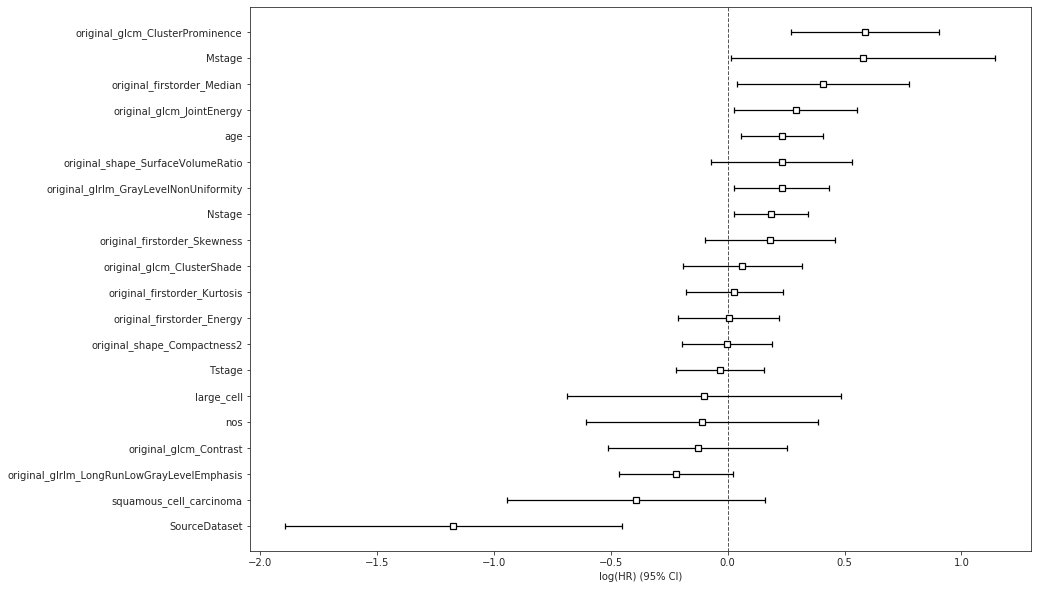

In [68]:
plt.figure(1, figsize=(14, 10))
cph.plot()

In [69]:
cph.score_

0.7274942377346065

In [70]:
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=4)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.6001034661148474, 0.7415103902686264, 0.7101610216546363, 0.71529284164859]
0.6917669299216751
0.05424115959678938


In [55]:
mean = []

for i in range(60):
    cph = CoxPHFitter()
    scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=4)
    mean.append(np.mean(scores))

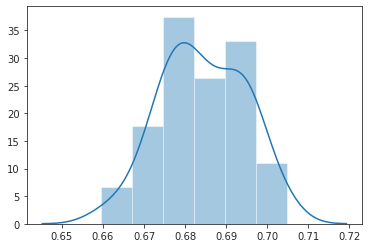

In [56]:
sns.distplot(mean)

#### Better variable selection with features testing

In [71]:
data_not_reduced = clinical.join([radiomics, target], how='left')
data_not_reduced.shape

(294, 61)

In [72]:
columns = ['adenocarcinoma', 'squamous_cell_carcinoma', 'large_cell', 'nos'] + list(data_not_reduced.columns[1:-2])
data_not_reduced.head()

,Histology,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,...,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
202,adenocarcinoma,0.0,0.0,l2,2.0,66.0000,0.027815,0.274892,48.559242,1.537964,...,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761,1378,0
371,large cell,0.0,2.0,l1,4.0,64.5722,0.023015,0.188210,75.703368,1.744961,...,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589,379,1
246,squamous cell carcinoma,0.0,3.0,l1,2.0,66.0452,0.027348,0.265740,70.434367,1.555420,...,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080,573,1
240,nos,0.0,2.0,l1,3.0,59.3566,0.026811,0.255406,46.818800,1.576120,...,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046,959,0
284,squamous cell carcinoma,0.0,3.0,l1,4.0,71.0554,0.023691,0.199424,53.795911,1.711620,...,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812,2119,0


In [73]:
# data
binary_cat_col = ['Mstage', 'Nstage', 'SourceDataset', 'Tstage']
cat_cols = ['Histology']
quant_cols = list(data_not_reduced.loc[:, 'age':].columns[:-2])

processing_data_forward = ColumnTransformer([
 ("encode_categorical_columns", OneHotEncoder(sparse=False, categories='auto'), cat_cols),
 ("encode_binary_categorical_columns", OrdinalEncoder(categories='auto'), binary_cat_col),             
 ("rescale_continue_columns", StandardScaler(), quant_cols)
 ])

X_not_reduced = pd.DataFrame(processing_data_forward.fit_transform(data_not_reduced.iloc[:, :-2]), index=data_not_reduced.index, columns=columns)
X_not_reduced['SurvivalTime'], X_not_reduced['Event'] = data_not_reduced['SurvivalTime'], data_not_reduced['Event']

X_not_reduced.head()

,adenocarcinoma,squamous_cell_carcinoma,large_cell,nos,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,...,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
202,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.293491,0.292416,...,-0.237848,0.864993,-0.174032,-0.274025,-0.160420,0.028410,-0.221691,-0.624654,1378,0
371,0.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,-0.444614,-0.482119,...,0.030167,-0.032454,-0.334973,0.100804,-0.360357,0.155210,-0.253849,-0.152758,379,1
246,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,-0.288707,0.217065,...,-0.102677,-0.902546,-0.379742,-0.479688,-0.426473,-0.809466,-0.204814,0.077147,573,1
240,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,-0.996650,0.130406,...,-0.451689,0.412382,-0.260455,-0.403524,-0.267589,-0.269188,-0.243214,-0.572159,959,0
284,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.241589,-0.373069,...,-0.466504,-0.255454,0.211200,1.242591,0.040251,1.360635,0.525069,0.134759,2119,0


In [47]:
steps, var_sorted = forward_selection(X_not_reduced.iloc[:, :62].values, y=X_not_reduced['SurvivalTime'].values, n_iter=62)

In [48]:
print('Ordre de sélection des variables : \n'
      '{} [...] {}'.format(var_sorted[:10], var_sorted[-10:]))

Ordre de sélection des variables : 
[46, 6, 30, 5, 8, 17, 10, 47, 0, 1] [...] [13, 41, 61, 49, 21, 38, 39, 27, 31, 26]


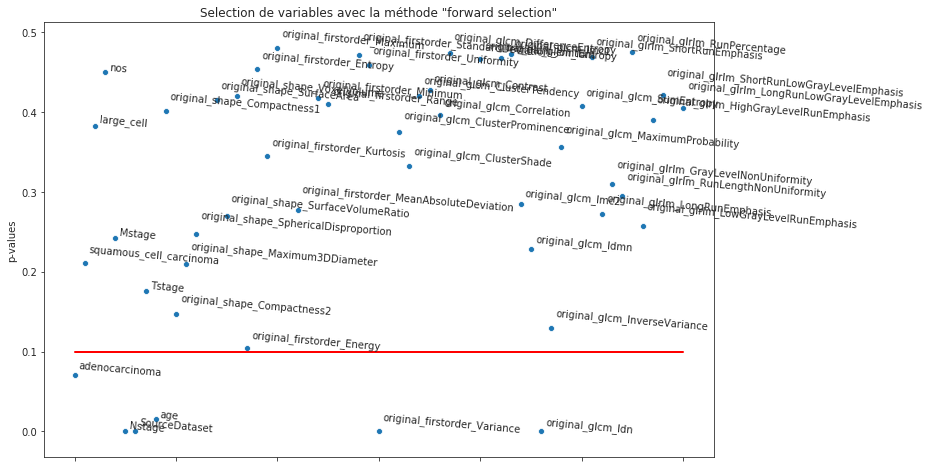

In [49]:
plt.figure(1, figsize=(12, 8))
p_values = []
for i in range(50):
    steps[i]['p_values'].sort()
    p_values.append(steps[i]['p_values'][0])

ax = sns.scatterplot(x=var_sorted[:50], y=p_values)
plt.plot(var_sorted[:50], [0.1 for i in range(len(var_sorted[:50]))], 'r')

plt.title("Selection de variables avec la méthode \"forward selection\"")
# Set y-axis label
plt.ylabel('p-values')
# Remove x-axis label
ax.set_xticklabels([])

for index, col in enumerate(var_sorted[:50]):
    ax.text(var_sorted[index]+.4, p_values[index], columns[col], rotation=-5)

The forward selection gives us a list of features that may be correlated with our `SurvivalTime`. We can take a few of them and apply an new CoxPH regression on theses covariates.

In [83]:
features = np.array(columns)[var_sorted[:19]]
X = X_not_reduced.loc[:, features].copy()
X['SurvivalTime'], X['Event'] = data['SurvivalTime'], data['Event']
X.head()

,original_glcm_Idn,SourceDataset,original_firstorder_Variance,Nstage,age,original_firstorder_Energy,original_shape_Compactness2,original_glcm_InverseVariance,adenocarcinoma,squamous_cell_carcinoma,...,original_glcm_Idmn,original_shape_Maximum3DDiameter,Mstage,original_shape_SphericalDisproportion,original_glcm_Imc2,original_glrlm_LowGrayLevelRunEmphasis,original_shape_SurfaceVolumeRatio,original_glrlm_LongRunEmphasis,SurvivalTime,Event
PatientID,,,,,,,,,,,,,,,,,,,,,
202,-0.847730,1.0,1.425562,0.0,-0.293491,0.228773,0.184211,-0.777966,1.0,0.0,...,-0.733123,-0.434880,0.0,-0.410895,0.194099,-0.174032,-0.344782,-0.681237,1378,0
371,0.259284,0.0,0.086414,2.0,-0.444614,0.068836,-0.575949,0.321631,0.0,1.0,...,0.424177,0.328405,0.0,0.232026,0.692459,-0.334973,-0.552043,-0.212022,379,1
246,0.580184,0.0,-0.940044,3.0,-0.288707,-0.333582,0.103954,0.806254,0.0,0.0,...,0.595807,0.180243,0.0,-0.356677,-0.070239,-0.379742,-0.792104,0.493356,573,1
240,0.164132,0.0,-0.412091,2.0,-0.996650,-0.411829,0.013334,0.530513,0.0,0.0,...,0.445723,-0.483821,0.0,-0.292383,0.214571,-0.260455,-0.052520,-0.518171,959,0
284,0.426887,0.0,-0.164680,3.0,0.241589,-0.382785,-0.477605,0.861544,0.0,0.0,...,0.365135,-0.287626,0.0,0.128471,0.350513,0.211200,-0.032319,-0.149504,2119,0


#### Yet another CoxPH regression

In [84]:
cph = CoxPHFitter()
cph.fit(X, 'SurvivalTime', event_col='Event')
cph.print_summary()

We can take a look to the hazard ratio of the covariate. As expected, the `original_glcm_Idn` play an important role in the estimate of the death. Thus, a one unit increase in `original_glcm_Idn` means that the baseline hazard will increase by a factor of $\exp(1.16)=3.20$. Other covariates as `original_shape_SurfaceVolumeRatio` or `original_firstorder_Variance` show a strong relation with the `SurvivalTime`. These features are caracteristics extrated from the image of the tumor, I think that with many good features from the tumor image we could achieve better performance on the prediction.

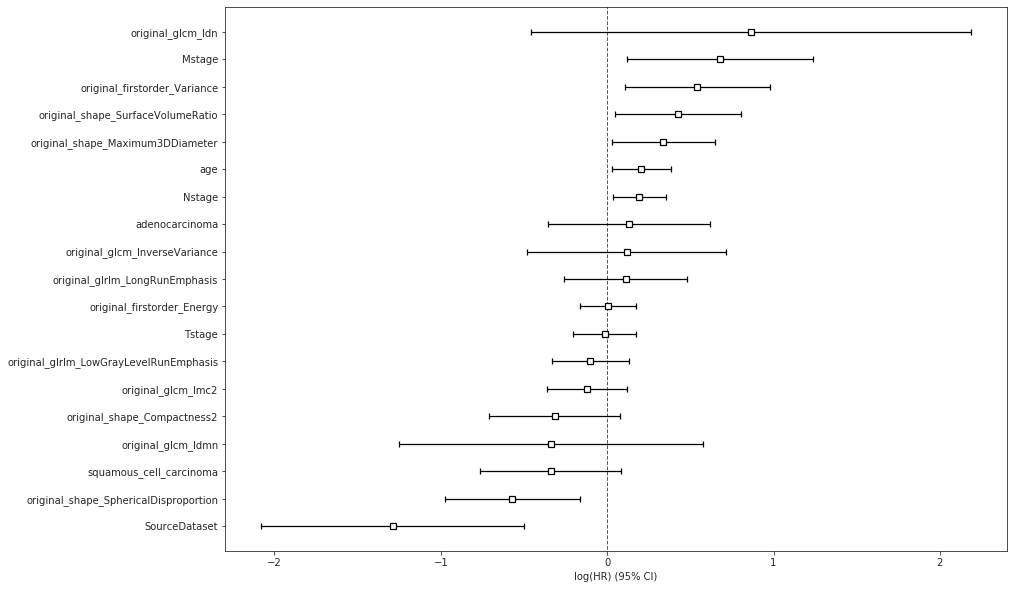

In [85]:
plt.figure(1, figsize=(14, 10))
cph.plot()

In [86]:
cph.score_

0.7260783668093513

In [87]:
cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=4)
print(scores)
print(np.mean(scores))
print(np.std(scores))

[0.6586666666666666, 0.6916183447548762, 0.6905140434552199, 0.7290562036055143]
0.6924638146205692
0.02492873125699808


In [88]:
mean = []

for i in range(60):
    cph = CoxPHFitter()
    scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=3)
    mean.append(np.mean(scores))

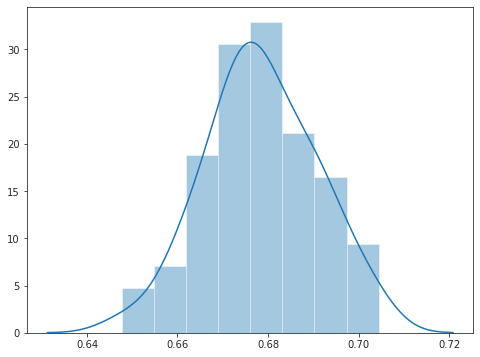

In [89]:
plt.figure(1, figsize=(8, 6))
sns.distplot(mean)

A little improvement on the variance of our model by adding features with the better chance to be correlated to the target. The probleme with VIF value is that it does not take $Y$ into account. So, we could remove a feature with a lot of information to understand the distribution of $Y$.

Instead, the forward selection method try to find which features is the must important to predict $Y$.

#### XGboost survival feature

An intuation that I have is to create a new feature from predictions of an XGboost survival model. 

In [92]:
X_xgboost, y_xgboost = X.iloc[:, :-2], X.loc[:, "SurvivalTime"]

xgb_full = xgboost.DMatrix(X_xgboost, label=y_xgboost)

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


In [93]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_full, 6000, verbose_eval=1000)

In [94]:
shap_values = shap.TreeExplainer(model_train).shap_values(X.iloc[:, :-2])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model. We can see below that the primary risk factor for death according to the model is belonging to the Source Dataset 1. The next most powerful indicator of death risk is the original shape surface volume ratio.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (such that a high original glcm Idmn leads to a high risk of death).

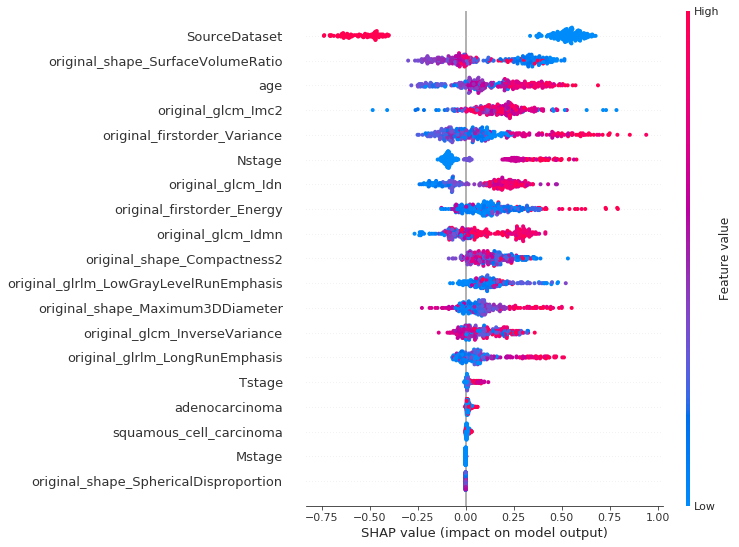

In [95]:
plt.figure(1, figsize=(14, 10))
shap.summary_plot(shap_values, X.iloc[:, :-2])

In [96]:
xgboost_features = model_train.predict(xgb_full, output_margin=False)

In [97]:
X.drop(['SurvivalTime', 'Event'], axis=1, inplace=True)
X['xgboost'] = xgboost_features
X['SurvivalTime'], X['Event'] = data['SurvivalTime'], data['Event']

In [98]:
cph = CoxPHFitter()
cph.fit(X, 'SurvivalTime', event_col='Event')
cph.print_summary()

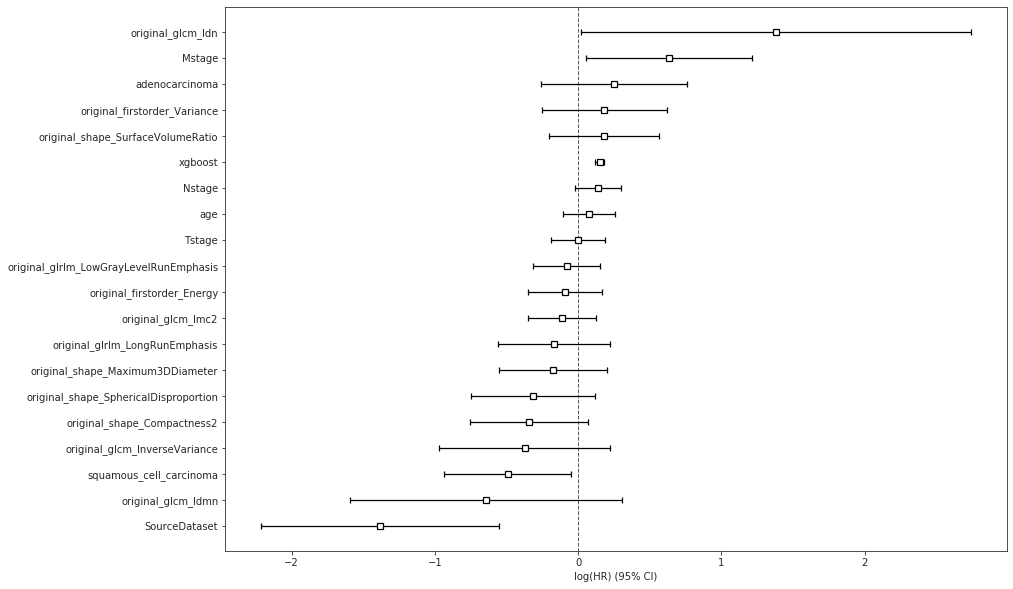

In [99]:
plt.figure(1, figsize=(14, 10))
cph.plot()

In [100]:
cph.score_

0.8252551860388542

In [101]:
mean = []

for i in range(60):
    cph = CoxPHFitter()
    scores = k_fold_cross_validation(cph, X, 'SurvivalTime', event_col='Event', k=4)
    mean.append(np.mean(scores))

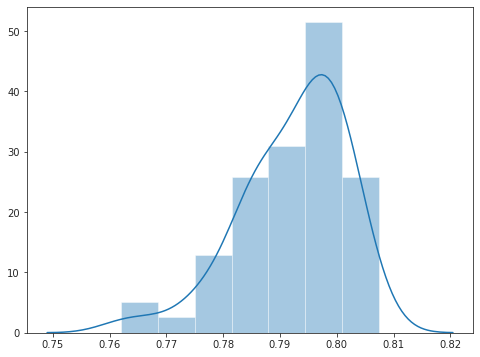

In [103]:
plt.figure(1, figsize=(8, 6))
sns.distplot(mean)

#### CoxNnet

In [107]:
data_x, y = X.iloc[:, :-2], X.loc[:, ['Event', 'SurvivalTime']].values
dtype = [('Event', '?'), ('SurvivalTime', '<f4')]
y = [(True, time) if event==1 else (False, time) for event, time in zip(y[:,0], y[:, 1])]
y = np.array(y, dtype=dtype)

In [108]:
data_x_train, data_x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2, random_state=42)

In [109]:
from datetime import datetime

date = str(datetime.now()).replace(' ', '_')
n_alphas = np.random.randint(low=10, high=150, size=5)
alpha_min_ratio = list(np.logspace(-3, -1, 5))
l1_ratio = np.random.uniform(low=0.1, high=1, size=5)
parameters = {'n_alphas': n_alphas, 'alpha_min_ratio': alpha_min_ratio,
              'l1_ratio': l1_ratio}

date = str(datetime.now()).replace(' ', '_')
grid_coxnet = train_model_gridsearch(model=CoxnetSurvivalAnalysis(), X=data_x_train, y=y_train,
                                  parameters=parameters, cv=4,
                                  output_path=model_path / f'grid_coxnet-{date}.joblib')

Generalization score for polynomial kernel: train:0.8795609827009739, test: 0.8987603305785123
Best params:  {'alpha_min_ratio': 0.01, 'l1_ratio': 0.8588947470288948, 'n_alphas': 145}


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [110]:
grid_coxnet.score(data_x_test, y_test)

0.9005897219882055

In [111]:
coxnet = CoxnetSurvivalAnalysis(**{'alpha_min_ratio': 0.1, 
                                   'l1_ratio': 0.8588947470288948, 
                                   'n_alphas': 145,
                                   'fit_baseline_model': True})
coxnet.fit(data_x_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.1, alphas=None, copy_X=True,
                       fit_baseline_model=True, l1_ratio=0.8588947470288948,
                       max_iter=100000, n_alphas=145, normalize=False,
                       penalty_factor=None, tol=1e-07, verbose=False)

In [112]:
coxnet.score(data_x_test, y_test)

0.9005897219882055


## Submission

In [113]:
radiomics_test, clinical_test = load_data(test_dir, target=False)
clinical_test.loc[clinical_test.Nstage == 4, 'Nstage'] = 1
clinical_test.loc[clinical_test.Tstage == 5, 'Tstage'] = 3

In [114]:
clinical_test = clinical_test.apply(lambda row: age_fillna(row, svr_age, features_processing_reg_age), axis=1)

In [115]:
clinical_test = clinical_test.apply(lambda row: hist_fillna(row, svc_hist,
                                                  features_processing_reg_hist), axis=1)

In [116]:
for index, row in clinical_test.iterrows():
  if row.isna().any():
    df = clinical[(clinical['Mstage'] == row.Mstage) &
              (clinical['Nstage'] == row.Nstage) &
              (clinical['SourceDataset'] == row.SourceDataset) &
              (clinical['Tstage'] == row.Tstage)]
    row.age = df.age.median()
    row.Histology = df.Histology.value_counts().index[0]
    clinical_test.loc[index, :] = row

In [118]:
features_selection_test = radiomics_test.copy()
data_test = clinical_test.join([features_selection_test], how='left')
columns = ['adenocarcinoma', 'squamous_cell_carcinoma', 'large_cell', 'nos'] + list(data_test.columns[1:])
data.shape

(294, 21)

In [119]:
# data
binary_cat_col = ['SourceDataset', 'Mstage', 'Nstage', 'Tstage']
cat_cols = ['Histology']
quant_cols = list(data.loc[:, 'age':].columns[:-2])

data_forward_test = pd.DataFrame(processing_data_forward.transform(data_test), index=data_test.index, columns=columns)

data_forward_test.head()

,adenocarcinoma,squamous_cell_carcinoma,large_cell,nos,Mstage,Nstage,SourceDataset,Tstage,age,original_shape_Compactness1,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
PatientID,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,-2.580023,0.465119,...,1.245600,2.324914,1.384686,-1.457353,-0.427073,-0.671441,-0.508732,-1.121330,-0.099096,0.191801
155,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,-0.577331,0.959442,...,-0.813696,-0.545082,-0.683913,1.310110,0.815180,-1.375602,0.972540,-1.215772,0.222068,-0.899882
404,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,-0.428388,-1.614445,...,0.478911,-0.111686,-0.256756,-0.904743,-0.466542,1.480212,-0.522503,1.299792,-0.277892,0.872444
407,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.360860,0.864115,...,-0.038222,-0.393061,-0.512585,-0.423282,-0.352339,1.296335,-0.386160,1.305577,-0.251776,0.225119
9,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.986983,-1.321433,...,-0.798069,-0.460207,-0.194789,1.228105,1.749405,-1.931457,2.095516,-1.979020,0.560862,-0.965041


In [125]:
X_test = data_forward_test.loc[:, features]
X.head()

,original_glcm_Idn,SourceDataset,original_firstorder_Variance,Nstage,age,original_firstorder_Energy,original_shape_Compactness2,original_glcm_InverseVariance,adenocarcinoma,squamous_cell_carcinoma,Tstage,original_glcm_Idmn,original_shape_Maximum3DDiameter,Mstage,original_shape_SphericalDisproportion,original_glcm_Imc2,original_glrlm_LowGrayLevelRunEmphasis,original_shape_SurfaceVolumeRatio,original_glrlm_LongRunEmphasis
PatientID,,,,,,,,,,,,,,,,,,,
13,1.229606,0.0,-1.205215,0.0,-2.580023,-0.148808,0.373281,1.259817,0.0,0.0,3.0,0.984004,1.205698,0.0,-0.529622,0.273570,-0.427073,-1.310172,1.245600
155,-1.663428,0.0,0.205106,3.0,-0.577331,-0.489050,0.953902,-1.698186,1.0,0.0,0.0,-1.311638,-1.271284,0.0,-0.832335,1.087610,0.815180,2.230300,-0.813696
404,0.863803,0.0,-0.969022,2.0,-0.428388,-0.410523,-1.428920,0.957035,0.0,1.0,1.0,0.754237,1.154495,0.0,1.718921,-0.249423,-0.466542,-0.104065,0.478911
407,0.787195,0.0,-0.724678,0.0,-0.360860,-0.467004,0.837382,1.230659,0.0,0.0,1.0,0.711085,-0.479623,0.0,-0.777808,0.019583,-0.352339,-0.303474,-0.038222
9,-1.247956,1.0,0.269531,0.0,-1.986983,1.236298,-1.237621,-1.615512,1.0,0.0,1.0,-1.019805,-0.210407,0.0,1.241270,-2.203800,1.749405,0.260788,-0.798069


In [126]:
xgb_test = xgboost.DMatrix(X_test)
xgboost_features_test = model_train.predict(xgb_test, output_margin=False)
X_test['xgboost'] = xgboost_features_test

In [127]:
X_test.head()

,original_glcm_Idn,SourceDataset,original_firstorder_Variance,Nstage,age,original_firstorder_Energy,original_shape_Compactness2,original_glcm_InverseVariance,adenocarcinoma,squamous_cell_carcinoma,Tstage,original_glcm_Idmn,original_shape_Maximum3DDiameter,Mstage,original_shape_SphericalDisproportion,original_glcm_Imc2,original_glrlm_LowGrayLevelRunEmphasis,original_shape_SurfaceVolumeRatio,original_glrlm_LongRunEmphasis,xgboost
PatientID,,,,,,,,,,,,,,,,,,,,
13,1.229606,0.0,-1.205215,0.0,-2.580023,-0.148808,0.373281,1.259817,0.0,0.0,3.0,0.984004,1.205698,0.0,-0.529622,0.273570,-0.427073,-1.310172,1.245600,17.610691
155,-1.663428,0.0,0.205106,3.0,-0.577331,-0.489050,0.953902,-1.698186,1.0,0.0,0.0,-1.311638,-1.271284,0.0,-0.832335,1.087610,0.815180,2.230300,-0.813696,3.094039
404,0.863803,0.0,-0.969022,2.0,-0.428388,-0.410523,-1.428920,0.957035,0.0,1.0,1.0,0.754237,1.154495,0.0,1.718921,-0.249423,-0.466542,-0.104065,0.478911,2.208663
407,0.787195,0.0,-0.724678,0.0,-0.360860,-0.467004,0.837382,1.230659,0.0,0.0,1.0,0.711085,-0.479623,0.0,-0.777808,0.019583,-0.352339,-0.303474,-0.038222,3.909125
9,-1.247956,1.0,0.269531,0.0,-1.986983,1.236298,-1.237621,-1.615512,1.0,0.0,1.0,-1.019805,-0.210407,0.0,1.241270,-2.203800,1.749405,0.260788,-0.798069,0.544020


The `Coxnet` class from scikit-survival package do not have a `predict_expectation` as CoxPH model from lifelines. To get the survival time we can integrate the survival fonction by the `Coxnet` model. The integrate is estimated with `trapz` from scipy package.

In [128]:
# Predict with the CoxPH model with elastic net penalty
patients = X_test.index
v = coxnet.predict_survival_function(X_test)
survival_df = pd.DataFrame(index=v[0].x)

for ind, patient in enumerate(patients):
    survival_df[patient] = v[ind].y

predictions = pd.DataFrame(trapz(survival_df.values.T, survival_df.index), index=patients)

In [ ]:
# Predict with the classic CoxPH model
predictions = cph.predict_expectation(X_test)

In [129]:
predictions.head()

,0
PatientID,
13,132.591017
155,700.212787
404,798.201644
407,619.084864
9,1006.859370


In [130]:
predictions.reset_index(inplace=True)
predictions.rename(columns={18: 'PatientID', 0: 'SurvivalTime'}, inplace=True)
predictions['Event'] = 'nan'

In [131]:
date = str(datetime.now()).replace(' ', '_')
predictions.to_csv(data_path / f"submission_{date}.csv", index=False)

## Next Step

In this section, I give some ideas that I could have applied to this challenge to improve the estimate of the patient's survival time:

- First, spending more time trying to find the good combination of features to estimate the survival time would have been great. 

- Then, I could have used more complex methods for the features extraction like a convolution neural network trained on a classification task (classify type of tumor for example). Once the network is trained, it's possible to extract some features from a new image by making a forward pass with it and get the weights of penultimate layer containing the most interesting features, for the classification task, of the image.

- It's possible to use Cox-neural network to directly apply a survival regression analysis on the data (the clinical dataset, the image or both of them). We can do that by modify the output layer of the network with a CoxPH loss.

- I could have improved my workflow by using a librairie as MLflow that allow us to keep a history of all models and have a user friendly strategies for deploying models. 

## Source

- [Variance inflaction factor - wiki](https://en.wikipedia.org/wiki/Variance_inflation_factor)
- [lifelines documentation](https://lifelines.readthedocs.io/)